In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
#NOTE: for LGD, EAD model, we don't care about weight of evidence. for discrete variables, We can simply create as many dummy variables as there are categories. And for continuous variables, can use them as they are, or transform them if 

# import data

In [4]:
path_datamart = r'C:\Users\DDD\Google Drive\Coding\Python\Credit Risk Modeling in Python\Datamart'
loan_data_preprocessed = pd.read_csv(os.path.join(path_datamart, 'loan_data_2007_2014_preprocessed.csv'), index_col=0)  # used the preprocessed data like what we have processed in the Data Prep notebook. However, for all population.
loan_data_preprocessed_backup = loan_data_preprocessed.copy()

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21,49) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# to compute LGD, EAD, need to allow sometimes for the customer to repay the owed amount. Plus, the lender could also take some action (sell house) to recover part of the debt --> only compute for those accounts that have been written off --> loan_status = Charged Off + Does not meet the credit policy.
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin([
    'Charged Off',
    'Does not meet the credit policy. Status:Charged Off'
])]

In [6]:
print(loan_data_preprocessed.shape)
print(loan_data_defaults.shape)

(466285, 208)
(43236, 208)


# data prep

## independent variable

In [7]:
loan_data_defaults.isnull().sum()       # count number of null rows in each variable
#NOTE: in any other occassion, have to consider whether imputing the variable is appropriate. In this current situation, it is sufficient to just impute missing values for Mths_since_last_delinq and Mths_since_last_record to be zero. 

Unnamed: 0.1             0
id                       0
member_id                0
loan_amnt                0
funded_amnt              0
                        ..
addr_state:WV            0
addr_state:WY            0
initial_list_status:f    0
initial_list_status:w    0
good_bad                 0
Length: 208, dtype: int64

In [8]:
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace=True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace=True)

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## dependent variable

### LGD = 1 - Recovery rate

In [9]:
# For LGD, usually work with recovery rate --> then derive LGD.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'].describe()

<ipython-input-9-5ed9733f8333>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [10]:
# since the max value of recovery rate is higher than 100% --> does not make sense --> adjust the recovery rate for extreme cases
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'].describe()

<ipython-input-10-d967ec590e58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
<ipython-input-10-d967ec590e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### EAD = total funded amount * credit conversion factor

In [11]:
# CCF = credit conversion factor = proportion of total exposure, at moment of default = what is remained in the principal, after deducting all of the principal payment the borrower has made. Expressed as % of funded amount
# CCF = 0 if all principal has been paid. = 1 if nothing has been paid
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

<ipython-input-11-8d071323b43e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']


count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [12]:
loan_data_defaults.to_csv(os.path.join(path_datamart, 'loan_data_defaults.csv'))

### visualise

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

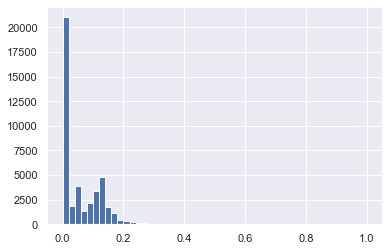

In [14]:
plt.hist(loan_data_defaults['recovery_rate'], bins=50)      # plot histogram recovery rate

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

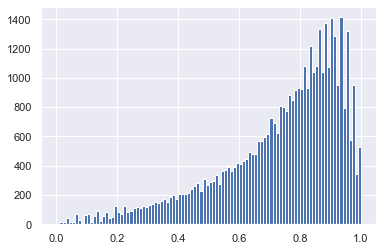

In [15]:
plt.hist(loan_data_defaults['CCF'], bins=100)      # plot histogram credit conversion factor

# procedure

In [16]:
#NOTE: The 2 LGD and EAD are constrained between 0 and 1 --> best described as Beta distribution --> but python does not have a package to regress Beta yet. Although R has. In this case, we will use logistic and linear regression

# LGD:
# 50% of the population has Recovery Rate of 0 --> create a boolean, to check if the Recovery Rate is 0, Logistic Regression. 
# if Recovery Rate is other than 0 --> use Linear Regression to estimate recovery rate. 

# CCF: 
# can use Linear Regression model

# LGD

## Stage 1: Logistic Regression

In [17]:
loan_data_defaults['recovery_rate_0_boolean'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1) # create boolean variable, if recovery rate is 0 or not

<ipython-input-17-6879da58c53c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_boolean'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1) # create boolean variable, if recovery rate is 0 or not


### split train & test dataset

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
LGD_inputs_stage_1_train, LGD_inputs_stage_1_test, LGD_targets_stage_1_train, LGD_targets_stage_1_test = train_test_split(
    loan_data_defaults.drop(['good_bad','recovery_rate','recovery_rate_0_boolean','CCF'], axis=1), 
    loan_data_defaults['recovery_rate_0_boolean'], 
    test_size=0.2,
    random_state=42
)

In [20]:
# create a list contains all dummies and continuous variables that would be used to predict LGD --> use the reference category list in PD model as this list
features_all = [
    'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'home_ownership:RENT',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:car',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:educational',
    'purpose:home_improvement',
    'purpose:house',
    'purpose:major_purchase',
    'purpose:medical',
    'purpose:moving',
    'purpose:other',
    'purpose:renewable_energy',
    'purpose:small_business',
    'purpose:vacation',
    'purpose:wedding',
    'initial_list_status:f',
    'initial_list_status:w',
    'term_int',
    'emp_length_int',
    'mths_since_issue_d',
    'mths_since_earliest_cr_line',
    'funded_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'total_rev_hi_lim'
]

In [21]:
# dummy variables for the discrete original variables = reference categories
features_reference_cat = [
    'grade:G',
    'home_ownership:RENT',
    'verification_status:Verified',
    'purpose:credit_card',
    'initial_list_status:f'
]

In [22]:
LGD_inputs_stage_1_train = LGD_inputs_stage_1_train[features_all] # in the train dataset, select only the columns in the feature all list 
LGD_inputs_stage_1_train.drop(features_reference_cat, axis=1, inplace=True) # drop the reference categories 
LGD_inputs_stage_1_train.isnull().sum()

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

### Logistic Regression with multivariate p-values

In [23]:
# similar to the PD model, create a custom function to regress linearly, with p-value
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_multivariate_pvalues:
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)   #inherete everything from the regression class

    # create new fit function, override fit() in the original class
    def fit(self, X, y):
        self.model.fit(X, y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [24]:
reg_LGD_stage1 = LogisticRegression_multivariate_pvalues(solver='lbfgs', max_iter=1000)
reg_LGD_stage1.fit(LGD_inputs_stage_1_train, LGD_targets_stage_1_train)

In [25]:
feature_name = LGD_inputs_stage_1_train.columns.values
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg_LGD_stage1.coef_)
summary_table.index = summary_table.index + 1   #add 1 to the index of the summary table
summary_table.loc[0] = ['Intercept', reg_LGD_stage1.intercept_[0]] #set intercept value as location 0 of the summary table df. The newly added row, index 0, would be at the bottom of the df
summary_table = summary_table.sort_index()      #sort the index from smallest to largest. Then assigned it back as the summary table
p_values = np.append(
    np.nan, 
    np.array(reg_LGD_stage1.p_values)
)
summary_table['p_values'] = p_values
summary_table
#NOTE: most are not statistically significant. 
#NOTE: for continuous variable. Coefficients = change in log(odds) that result from a unit change of continuous variable.

,Feature name,Coefficients,p_values
0,Intercept,-4.514037e-04,NaN
1,grade:A,-8.356441e-05,9.992214e-01
2,grade:B,-3.292075e-04,9.961983e-01
3,grade:C,-4.755977e-04,9.942997e-01
4,grade:D,6.253793e-05,9.992796e-01
5,grade:E,7.097406e-05,9.992585e-01
6,grade:F,2.580541e-04,9.976536e-01
7,home_ownership:MORTGAGE,-9.556181e-05,9.970201e-01
8,home_ownership:NONE,2.813559e-06,9.999972e-01
9,home_ownership:OTHER,-9.463333e-07,9.999982e-01


### validate model accuracy

#### predict test dataset (input)

In [27]:
# use the test data, but only take the features that we used to train on
LGD_inputs_stage_1_test = LGD_inputs_stage_1_test[features_all]
LGD_inputs_stage_1_test.drop(features_reference_cat, axis=1, inplace=True) # drop the reference categories 
LGD_inputs_stage_1_test

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
178928,0,0,0,1,0,0,1,0,0,0,...,21.69,0.0,3.0,54.0,0.0,10.0,0.0,25.0,0.0,8400.0
69814,1,0,0,0,0,0,0,0,0,0,...,7.75,0.0,0.0,0.0,0.0,5.0,0.0,9.0,0.0,5600.0
101396,0,0,0,0,0,1,0,0,0,0,...,21.99,1.0,0.0,12.0,97.0,9.0,1.0,16.0,0.0,21900.0
463268,1,0,0,0,0,0,0,0,0,0,...,12.45,0.0,0.0,0.0,0.0,12.0,0.0,27.0,0.0,20100.0
253729,0,0,0,1,0,0,0,0,0,1,...,19.51,0.0,2.0,36.0,0.0,20.0,0.0,32.0,0.0,80400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125763,0,1,0,0,0,0,1,0,0,0,...,15.97,1.0,1.0,15.0,0.0,10.0,0.0,21.0,0.0,12000.0
224662,1,0,0,0,0,0,0,0,0,0,...,17.78,0.0,0.0,0.0,0.0,5.0,0.0,15.0,0.0,12800.0
139775,0,0,1,0,0,0,0,0,0,1,...,17.76,0.0,1.0,0.0,111.0,6.0,1.0,10.0,0.0,19200.0
191791,0,0,0,0,1,0,1,0,0,0,...,20.77,0.0,0.0,0.0,0.0,12.0,0.0,29.0,0.0,43000.0


In [32]:
# predict data using the multivariate Logistic Regression instance above --> store result in y_hat = estimated recovery rate as either zero (=0) or not zero (=1)
y_hat_test_LGD_stage1 = reg_LGD_stage1.model.predict(LGD_inputs_stage_1_test)
y_hat_test_LGD_stage1

array([1, 1, 0, ..., 1, 1, 0])

In [33]:
# use the method predict probability to get exact recovery rate
y_hat_test_proba_LGD_stage1 = reg_LGD_stage1.model.predict_proba(LGD_inputs_stage_1_test)
y_hat_test_proba_LGD_stage1
#NOTE: see PD model >>> out of sample validation, the predict_proba returns 2 values for each row: first is the probability of getting 0, second is the probability of getting 1. In this case we only interested in probability of getting 1, i.e., probability of getting more than 0% recovery rate

array([[0.412891  , 0.587109  ],
       [0.3736221 , 0.6263779 ],
       [0.59626604, 0.40373396],
       ...,
       [0.49715028, 0.50284972],
       [0.41892862, 0.58107138],
       [0.55423277, 0.44576723]])

In [34]:
# probability of getting more than 0% recovery rate --> use this to compare this estimated recovery rate against actual recovery rate
y_hat_test_proba_LGD_stage1 = y_hat_test_proba_LGD_stage1[:][:, 1]
y_hat_test_proba_LGD_stage1

array([0.587109  , 0.6263779 , 0.40373396, ..., 0.50284972, 0.58107138,
       0.44576723])

#### compare with test dataset (target)

In [40]:
LGD_targets_stage_1_test_copy = LGD_targets_stage_1_test    # take a copy of target test dataset
LGD_targets_stage_1_test_copy.reset_index(drop=True, inplace=True)      # reset index
df_actual_predicted_proba = pd.concat([LGD_targets_stage_1_test_copy, pd.DataFrame(y_hat_test_proba_LGD_stage1)], axis=1)     # combine this df with the predicted probab df above
df_actual_predicted_proba.columns = ['LGD_targets_stage_1_test','y_hat_test_proba_LGD_stage1']
df_actual_predicted_proba.index = LGD_inputs_stage_1_test.index   # set index to similar to the input test dataset
df_actual_predicted_proba

,LGD_targets_stage_1_test,y_hat_test_proba_LGD_stage1
178928,1,0.587109
69814,1,0.626378
101396,0,0.403734
463268,1,0.551364
253729,0,0.425850
...,...,...
125763,1,0.567909
224662,0,0.673034
139775,1,0.502850
191791,1,0.581071


#### use Confusion Matrix

In [41]:
tr = 0.5    # set threshold value
df_actual_predicted_proba['y_hat_test_LGD_stage1'] = np.where(df_actual_predicted_proba['y_hat_test_proba_LGD_stage1'] > tr,1,0)

In [43]:
pd.crosstab(
    df_actual_predicted_proba['LGD_targets_stage_1_test'], 
    df_actual_predicted_proba['y_hat_test_LGD_stage1'],
    rownames= ['Actual'],
    colnames= ['Predicted']
)   # confusion matrix: actual value as rows, predicted value as columns

Predicted,0,1
Actual,,
0,1536,2226
1,1060,3826


In [45]:
crosstab_prcnt = pd.crosstab(
    df_actual_predicted_proba['LGD_targets_stage_1_test'], 
    df_actual_predicted_proba['y_hat_test_LGD_stage1'],
    rownames= ['Actual'],
    colnames= ['Predicted']
)   / df_actual_predicted_proba.shape[0]
crosstab_prcnt

Predicted,0,1
Actual,,
0,0.177613,0.257401
1,0.122572,0.442414


In [46]:
crosstab_prcnt.iloc[0,0] + crosstab_prcnt.iloc[1,1]  # overall accuracy of the model

0.6200277520814061

#### use ROC curve

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, threshold = roc_curve(
    df_actual_predicted_proba['LGD_targets_stage_1_test'],
    df_actual_predicted_proba['y_hat_test_LGD_stage1']
)       #roc_curve() output 3 arrays: false positive rate, true positive rate, threshold --> we assign them to 3 variables

Text(0.5, 1.0, 'ROC curve')

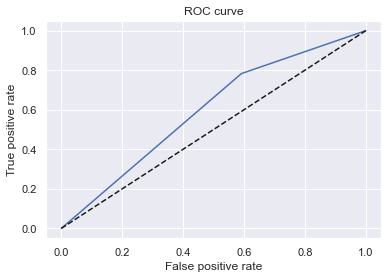

In [48]:
plt.plot(fpr, tpr)   # plotting the ROC curve: false positive rate along the x-axis and the true positive rate along the y-axis,
plt.plot(fpr, fpr, linestyle = '--', color = 'k')   # seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')   # name the x-axis "False positive rate".
plt.ylabel('True positive rate')    # name the x-axis "True positive rate".
plt.title('ROC curve')  # name the graph "ROC curve".

In [50]:
AUROC = roc_auc_score(
    df_actual_predicted_proba['LGD_targets_stage_1_test'],
    df_actual_predicted_proba['y_hat_test_LGD_stage1']
)   
AUROC   #compute AUC of our model
#NOTE: 60% --> good but not great
#NOTE: although, it is important to have values larger than 0 being classified correctly, than to have correctly classified 0. Because in the 2nd stage model, some values that were currently classifed as more than 0, may still be estimated as being 0 --> thus correcting the current misclassification. 

0.5956735417601049

### save Stage 1 model

In [51]:
# saving a model = create a file that contain all information regarding the machine learning: 
# - Model = logistic regression. 
# - Coefficients & intercept
# - Random state 
# - Test size = 20%...

# since reg_LGD_stage1 is an instance of the multivariate Logistic Regression, it computes and contains the coefficients, intercept, p-values, ... --> saving the model is equivalent to save this reg_LGD_stage1 object

In [53]:
# python module pickle converts python objects in character stream (string) --> this stream contains sufficient information --> later on we can use this character stream to unpickle into a python object
# Benefit: the pickle file is tiny
import pickle
pickle.dump(reg_LGD_stage1, open('lgd_model_stage_1.sav', 'wb'))

## Stage 2: Linear Regression

In [54]:
# using multiple linear regression model to estimate recovery rates for accounts where their actual recovery rate is higher than 0

In [75]:
LGD_stage2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_boolean'] == 1]

### split train & test dataset

In [84]:
LGD_inputs_stage_2_train, LGD_inputs_stage_2_test, LGD_targets_stage_2_train, LGD_targets_stage_2_test = train_test_split(
    LGD_stage2_data.drop(['good_bad','recovery_rate','recovery_rate_0_boolean','CCF'], axis=1), 
    LGD_stage2_data['recovery_rate'], 
    test_size=0.2,
    random_state=42
)

In [85]:
# prepare the train dataset 
LGD_inputs_stage_2_train = LGD_inputs_stage_2_train[features_all] # in the train dataset, select only the columns in the feature all list 
LGD_inputs_stage_2_train.drop(features_reference_cat, axis=1, inplace=True) # drop the reference categories 

### Linear Regression with multivariate p-values

In [86]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [87]:
# similar to the Logistic Regression model, sklearn does not provide p-values --> create a custom function 
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [88]:
reg_LGD_stage2 = LinearRegression()
reg_LGD_stage2.fit(LGD_inputs_stage_2_train, LGD_targets_stage_2_train)

LinearRegression()

In [89]:
feature_name = LGD_inputs_stage_2_train.columns.values
summary_table = pd.DataFrame(columns=['Feature name'], data=feature_name)
summary_table['Coefficients'] = np.transpose(reg_LGD_stage2.coef_)
summary_table.index = summary_table.index + 1   #add 1 to the index of the summary table
summary_table.loc[0] = ['Intercept', reg_LGD_stage2.intercept_] #set intercept value as location 0 of the summary table df. The newly added row, index 0, would be at the bottom of the df
summary_table = summary_table.sort_index()      #sort the index from smallest to largest. Then assigned it back as the summary table
p_values = np.append(
    np.nan, 
    np.array(reg_LGD_stage2.p)
)
summary_table['p_values'] = p_values
summary_table
#NOTE: most coefficients are statistically significant
#NOTE: interpreation: if the purpose of the loan is education, then the recovery rate of would be 7.63% higher than when the purpose is credit card
#NOTE: interpreation: for any 1% increase in interest rate, the recovery rate is lower by 0.025

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000000e+00
2,grade:B,-5.083556e-02,0.000000e+00
3,grade:C,-3.748066e-02,0.000000e+00
4,grade:D,-2.717310e-02,1.970424e-12
5,grade:E,-1.315941e-02,1.918578e-03
6,grade:F,-5.260168e-03,2.748685e-01
7,home_ownership:MORTGAGE,2.832212e-03,6.050271e-02
8,home_ownership:NONE,1.459035e-01,9.092582e-05
9,home_ownership:OTHER,-9.475922e-03,6.436926e-01


### validate model accuracy

#### predict test dataset (input)

In [90]:
LGD_inputs_stage_2_test = LGD_inputs_stage_2_test[features_all] # use the test data, but only take the features that we used to train on
LGD_inputs_stage_2_test.drop(features_reference_cat, axis=1, inplace=True) # drop the reference categories 
y_hat_test_LGD_stage2 = reg_LGD_stage2.predict(LGD_inputs_stage_2_test) # predict data using the multivariate Linear Regression instance above 
y_hat_test_LGD_stage2

array([0.09411793, 0.15456357, 0.13061439, ..., 0.11716741, 0.11144037,
       0.12314059])

#### compare with test dataset (target)

In [94]:
LGD_targets_stage_2_test_copy = LGD_targets_stage_2_test    # take a copy of target test dataset
LGD_targets_stage_2_test_copy.reset_index(drop=True, inplace=True)      # reset index
df_actual_predicted2 = pd.concat([LGD_targets_stage_2_test_copy, pd.DataFrame(y_hat_test_LGD_stage2)], axis=1)     # combine this df with the predicted probab df above
df_actual_predicted2.columns = ['LGD_targets_stage_2_test','y_hat_test_LGD_stage2']
df_actual_predicted2.index = LGD_inputs_stage_2_test.index   # set index to similar to the input test dataset
df_actual_predicted2

,LGD_targets_stage_2_test,y_hat_test_LGD_stage2
221921,0.033254,0.094118
338754,0.156128,0.154564
45237,0.181260,0.130614
13641,0.035356,0.083299
223984,0.046756,0.077058
...,...,...
133866,0.000940,0.099824
266256,0.141676,0.165443
113401,0.094708,0.117167
94097,0.095061,0.111440


#### use correlation between actual & predicted

In [95]:
# can use correlation to compare the predicted value and the actual values
df_actual_predicted2.corr()
#NOTE: the correlation of 0.308 is weak in general. But satisfy the LGD model. In fact, if the correlation is too high, the model would be questionable. 

,LGD_targets_stage_2_test,y_hat_test_LGD_stage2
LGD_targets_stage_2_test,1.000000,0.307996
y_hat_test_LGD_stage2,0.307996,1.000000


#### evaluate residual of (actual & predicted)

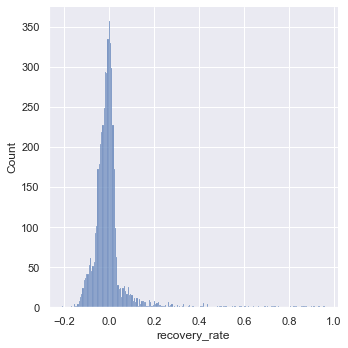

In [96]:
# residual of (actual & predicted) = difference between (actual and predicted values) --> if the residual is close to normal and have mean of zero, the actual and predicted value would be alike. 
sns.displot(LGD_targets_stage_2_test - y_hat_test_LGD_stage2)    # plot distribution of the residual of (actual & predicted)
#NOTE: satisfied

### save Stage 2 model

In [97]:
pickle.dump(reg_LGD_stage2, open('lgd_model_stage_2.sav', 'wb'))

## Combine Stage 1 and Stage 2

In [98]:
# use stage 2 model to predict all values in the test dataset. The LGD_inputs_stage_1_test dataset does not exclude where actual recovery rate is greater than 0 --> use that dataset to predict
y_hat_test_LGD_stage2_all = reg_LGD_stage2.predict(LGD_inputs_stage_1_test)
y_hat_test_LGD_stage2_all   # contains estimated recovery rate by linear regression, regardless whether they are predicted to be 0 or 1 by the 1st stage

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [101]:
# double check the shape of test y_hat Stage1 and test y_hat Stage2
print(y_hat_test_LGD_stage1.shape)
print(y_hat_test_LGD_stage2_all.shape)

(8648,)
(8648,)


In [ ]:
# can combine recovery estimation by: multiplying the predicted values of Stage 1 with predicted values of Stage 2 <-- because:
# - if Stage 1 model predicts that value recovery rate would be 0 (meaning 0 recovery rate), multiply it by the Stage 2 predicted value would still yield 0 recovery rate in overall. 
# - if Stage 1 model predicts that value recovery rate would be 1 (meaning more than 0 recovery rate), multiply it by the Stage 2 predicted value would still yield Stage 2's recovery rate in overall.

In [103]:
y_hat_test_LGD = y_hat_test_LGD_stage1 * y_hat_test_LGD_stage2_all

In [104]:
pd.DataFrame(y_hat_test_LGD).describe()
#NOTE: minimum values is less than 0 --> meaning negative recovery rate --> not make sense --> this is because the Linear Regression is not constraint by negative values

,0
count,8648.000000
mean,0.072669
std,0.052901
min,-0.007634
25%,0.000000
50%,0.090149
75%,0.115106
max,0.236973


In [105]:
# adjust predicted values
y_hat_test_LGD = np.where(y_hat_test_LGD < 0 , 0, y_hat_test_LGD)
y_hat_test_LGD = np.where(y_hat_test_LGD > 1 , 1, y_hat_test_LGD)
pd.DataFrame(y_hat_test_LGD).describe()

,0
count,8648.000000
mean,0.072671
std,0.052898
min,0.000000
25%,0.000000
50%,0.090149
75%,0.115106
max,0.236973
